## Introduction

This notebook is dedicated to create the Loan subgrade classification model. I will be using lightgbm Classifier for this task.

## Importing necessary libraries

In [1]:
from lightgbm import LGBMClassifier

import functions as f
import pandas as pd
pd.set_option("display.max_columns", None)

from functions import CustomOrdinalEncoder, CustomWordExtractor, CustomCategoricalConverter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report

import shap
shap.initjs()

import pickle

/Users/laurynas/anaconda3/envs/model-env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/laurynas/anaconda3/envs/model-env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def

## Importing Train and Test sets from EDA Notebook

In [2]:
train_set = pd.read_csv(
    "/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/train_set_df_2.csv",
    low_memory=False,
)
test_set = pd.read_csv(
    "/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/test_set_df_2.csv",
    low_memory=False,
)

In [3]:
X_train = train_set.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d", "earliest_cr_line"], axis=1
)
y_train = train_set["sub_grade"]

## Building the Pipeline

In [4]:
emp_length_order = [
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
verification_status_order = [
    "Not Verified",
    "Verified",
    "Source Verified",
]
cat_features = [
    "home_ownership",
    "zip_code",
    "state",
    "initial_list_status",
    "application_type",
    "hardship_flag",
]
custom_word_pipeline = Pipeline(
    steps=[
        ("word_extractor", CustomWordExtractor(column_name=["emp_title", "purpose"])),
        (
            "ordinal_encoder",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
        ),
    ]
)
preprocess_pipeline = ColumnTransformer(
    transformers=[
        (
            "employment_length_encoder",
            CustomOrdinalEncoder(
                column_name="employment_length", order=emp_length_order
            ),
            ["employment_length"],
        ),
        (
            "verification_status_encoder",
            CustomOrdinalEncoder(
                column_name="verification_status", order=verification_status_order
            ),
            ["verification_status"],
        ),
        ("custom_word_pipeline", custom_word_pipeline, ["emp_title", "purpose"]),
        (
            "cat_encoding",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_features,
        ),
    ],
    remainder="passthrough",
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('employment_length_encoder',
                                 CustomOrdinalEncoder(column_name='employment_length',
                                                      order=['< 1 year',
                                                             '1 year',
                                                             '2 years',
                                                             '3 years',
                                                             '4 years',
                                                             '5 years',
                                                             '6 years',
                                                             '7 years',
                                                             '8 years',
                                                             '9 years',
                                                             '10+ years']),
                                 ['employment_length']),
                                ('verification_status_encoder',
                                 CustomOrdinalEncoder(column_name='verification_st...
                                                  CustomWordExtractor(column_name=['emp_title',
                                                                                   'purpose'])),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(encoding_method='arbitrary',
                                                                 missing_values='ignore',
                                                                 unseen='encode'))]),
                                 ['emp_title', 'purpose']),
                                ('cat_encoding',
                                 OrdinalEncoder(encoding_method='arbitrary',
                                                missing_values='ignore',
                                                unseen='encode'),
                                 ['home_ownership', 'zip_code', 'state',
                                  'initial_list_status', 'application_type',
                                  'hardship_flag'])])

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [6]:
cat_features = [
    "employment_length_encoder__employment_length",
    "verification_status_encoder__verification_status",
    "custom_word_pipeline__emp_title",
    "custom_word_pipeline__purpose",
    "cat_encoding__home_ownership",
    "cat_encoding__zip_code",
    "cat_encoding__state",
    "cat_encoding__initial_list_status",
    "cat_encoding__application_type",
    "cat_encoding__hardship_flag",
]
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_features),
        ),
    ]
)
X_train_transform = pipeline.fit_transform(X_train)
X_valid_transform = pipeline.transform(X_valid)

In [7]:
classifier = LGBMClassifier(random_state=1, n_jobs=-1, objective="multiclass")
classifier.fit(
    X_train_transform,
    y_train,
    early_stopping_rounds=15,
    eval_set=[(X_valid_transform, y_valid)],
    verbose=-1,
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMClassifier(objective='multiclass', random_state=1)

MODEL EVALUATION ON TRAINING SET
              precision    recall  f1-score   support

          A1       0.57      0.74      0.64     55764
          A2       0.39      0.38      0.38     44329
          A3       0.38      0.31      0.34     46969
          A4       0.34      0.36      0.35     61449
          A5       0.37      0.50      0.43     68782
          B1       0.34      0.36      0.35     80201
          B2       0.36      0.31      0.34     80923
          B3       0.34      0.32      0.33     84180
          B4       0.41      0.48      0.44     89112
          B5       0.37      0.43      0.40     89786
          C1       0.35      0.46      0.40     93449
          C2       0.34      0.31      0.32     83805
          C3       0.36      0.33      0.34     82678
          C4       0.31      0.41      0.36     81368
          C5       0.34      0.37      0.35     74827
          D1       0.42      0.23      0.30     52349
          D2       0.41      0.25      0.31     

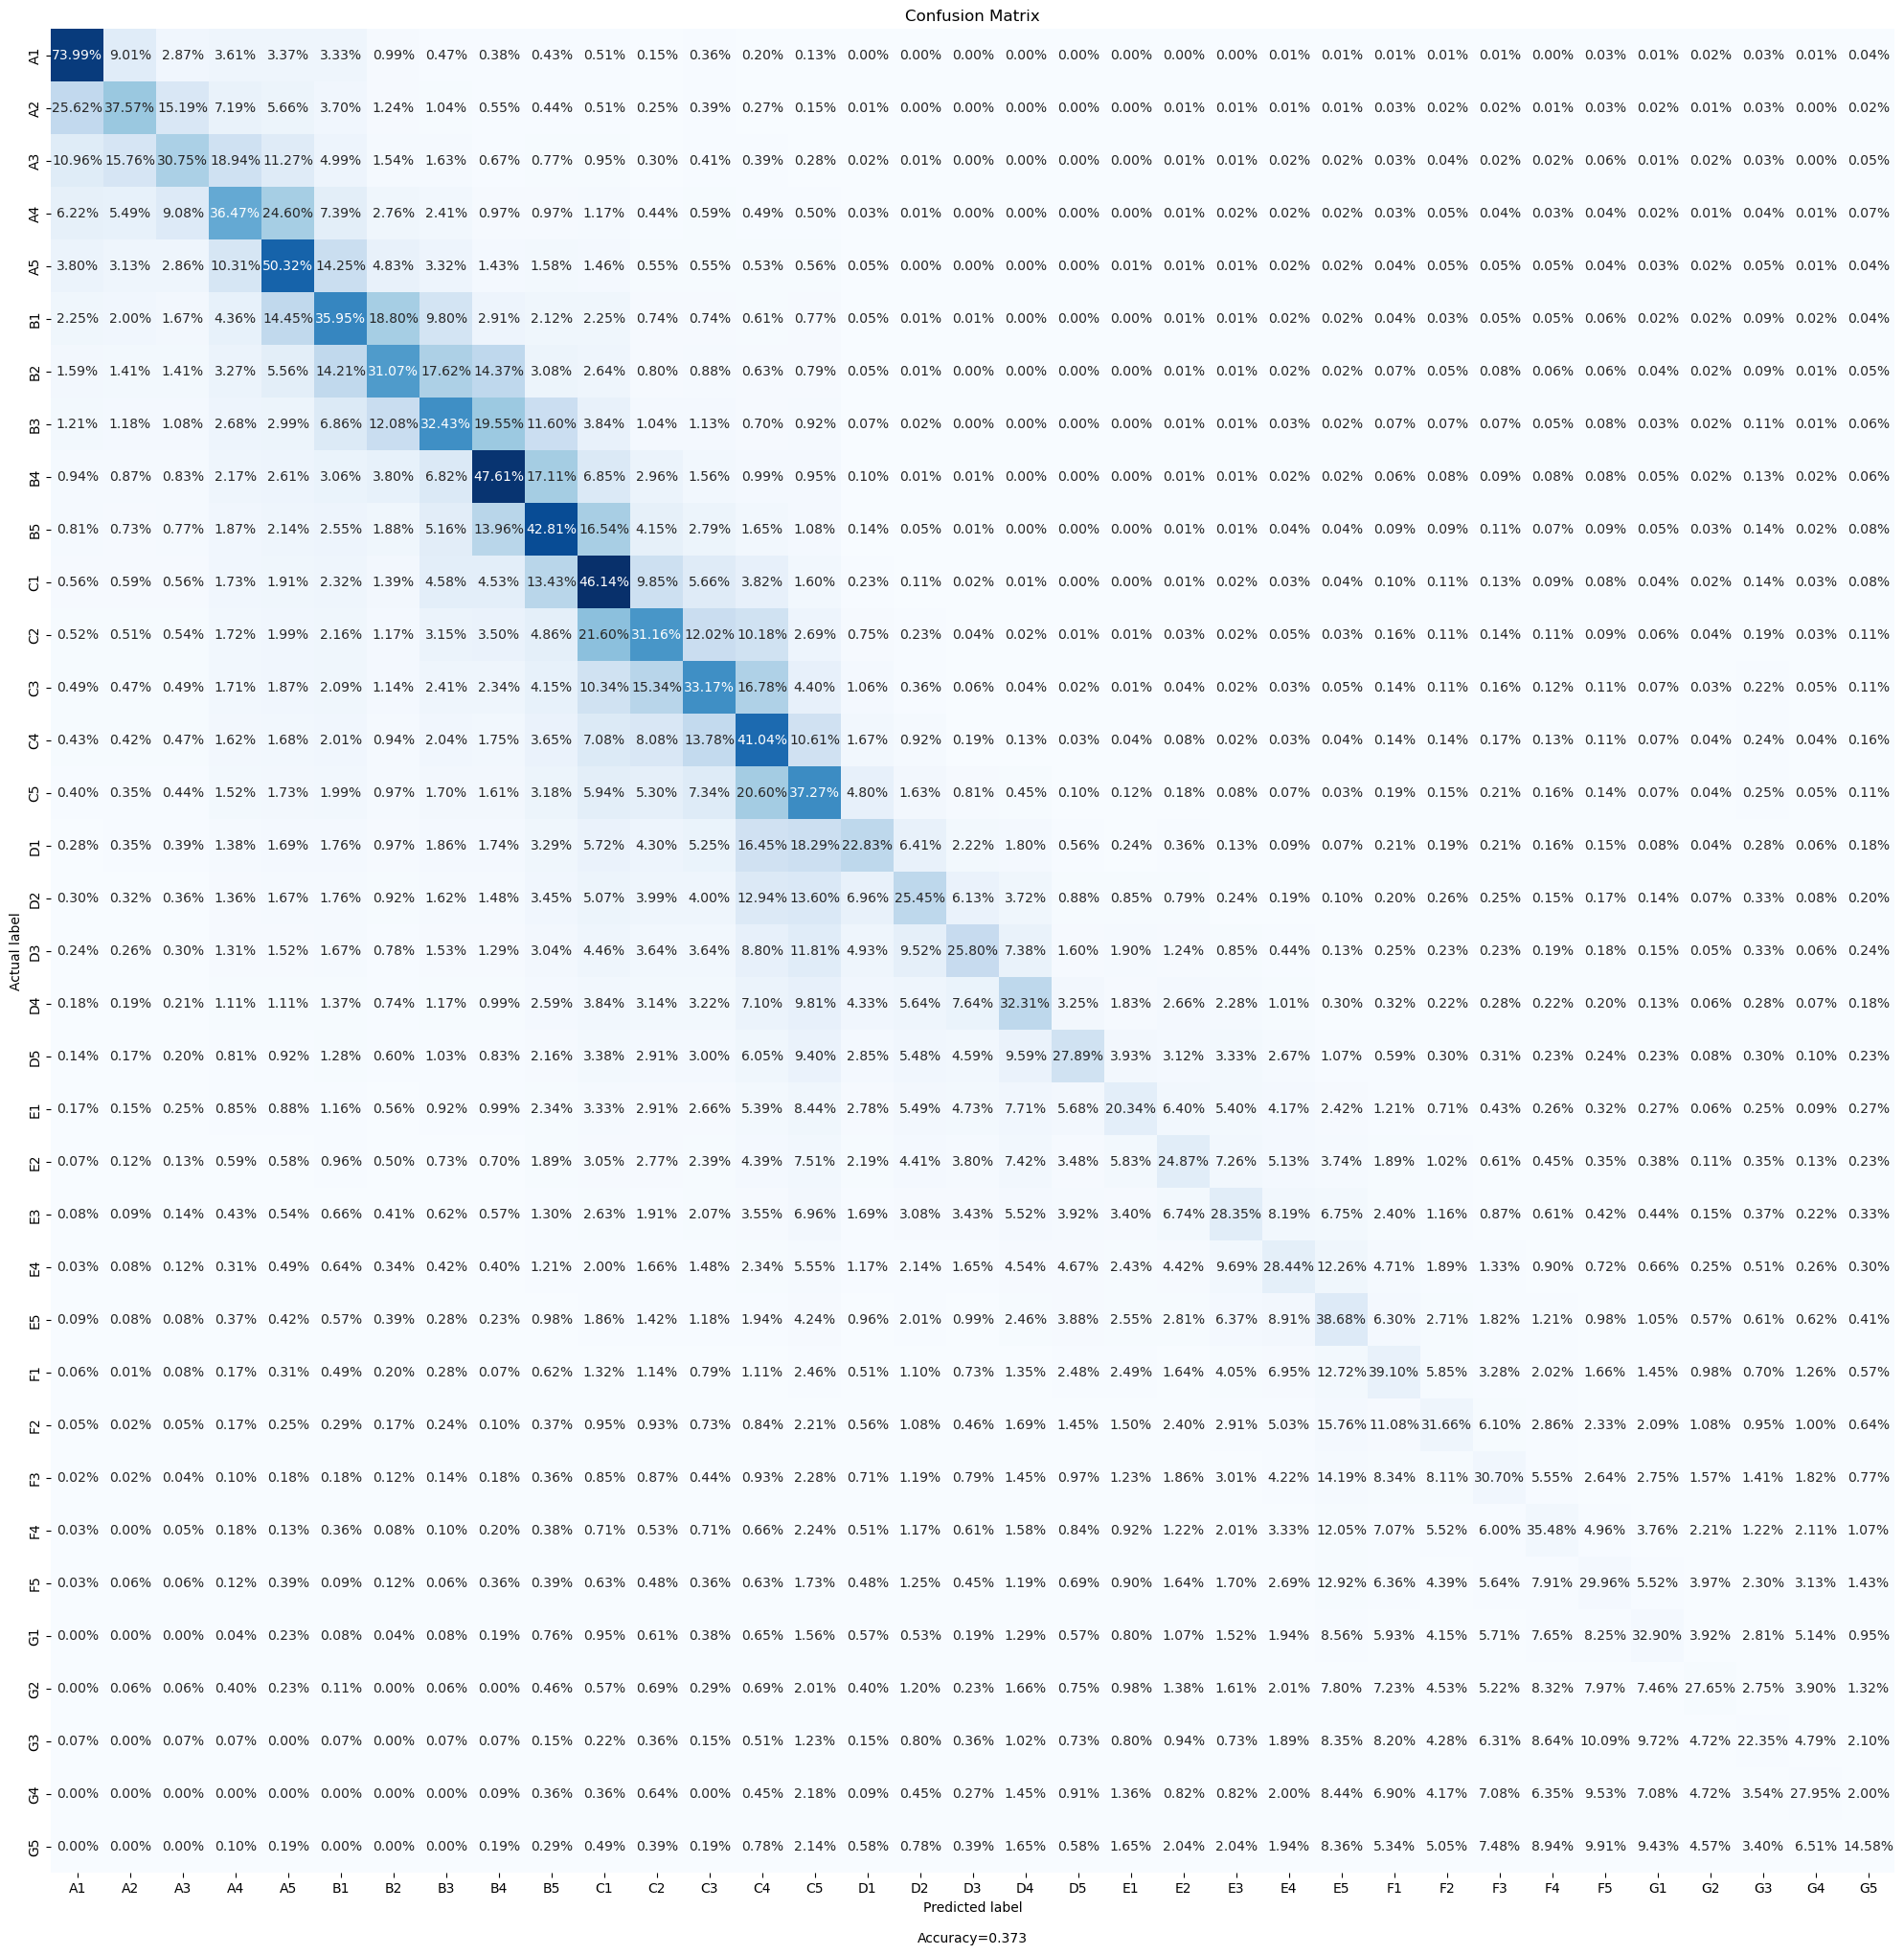

In [8]:
categories = [
    "A1",
    "A2",
    "A3",
    "A4",
    "A5",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "C1",
    "C2",
    "C3",
    "C4",
    "C5",
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "E1",
    "E2",
    "E3",
    "E4",
    "E5",
    "F1",
    "F2",
    "F3",
    "F4",
    "F5",
    "G1",
    "G2",
    "G3",
    "G4",
    "G5",
]
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict(X_train_transform)
print(classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
f.plot_confusion_matrix(cm, figsize=(25, 25), categories=categories, count=None)

MODEL EVALUATION ON VALIDATION SET
              precision    recall  f1-score   support

          A1       0.56      0.72      0.63     13808
          A2       0.38      0.36      0.37     11220
          A3       0.34      0.28      0.31     11629
          A4       0.33      0.35      0.34     15277
          A5       0.36      0.49      0.41     17253
          B1       0.33      0.35      0.34     20070
          B2       0.35      0.30      0.32     20390
          B3       0.32      0.31      0.32     21013
          B4       0.41      0.47      0.44     22491
          B5       0.36      0.41      0.38     22357
          C1       0.34      0.45      0.39     23326
          C2       0.31      0.28      0.30     20922
          C3       0.33      0.31      0.32     20647
          C4       0.29      0.38      0.33     20444
          C5       0.31      0.34      0.32     18605
          D1       0.37      0.20      0.26     13052
          D2       0.37      0.23      0.28   

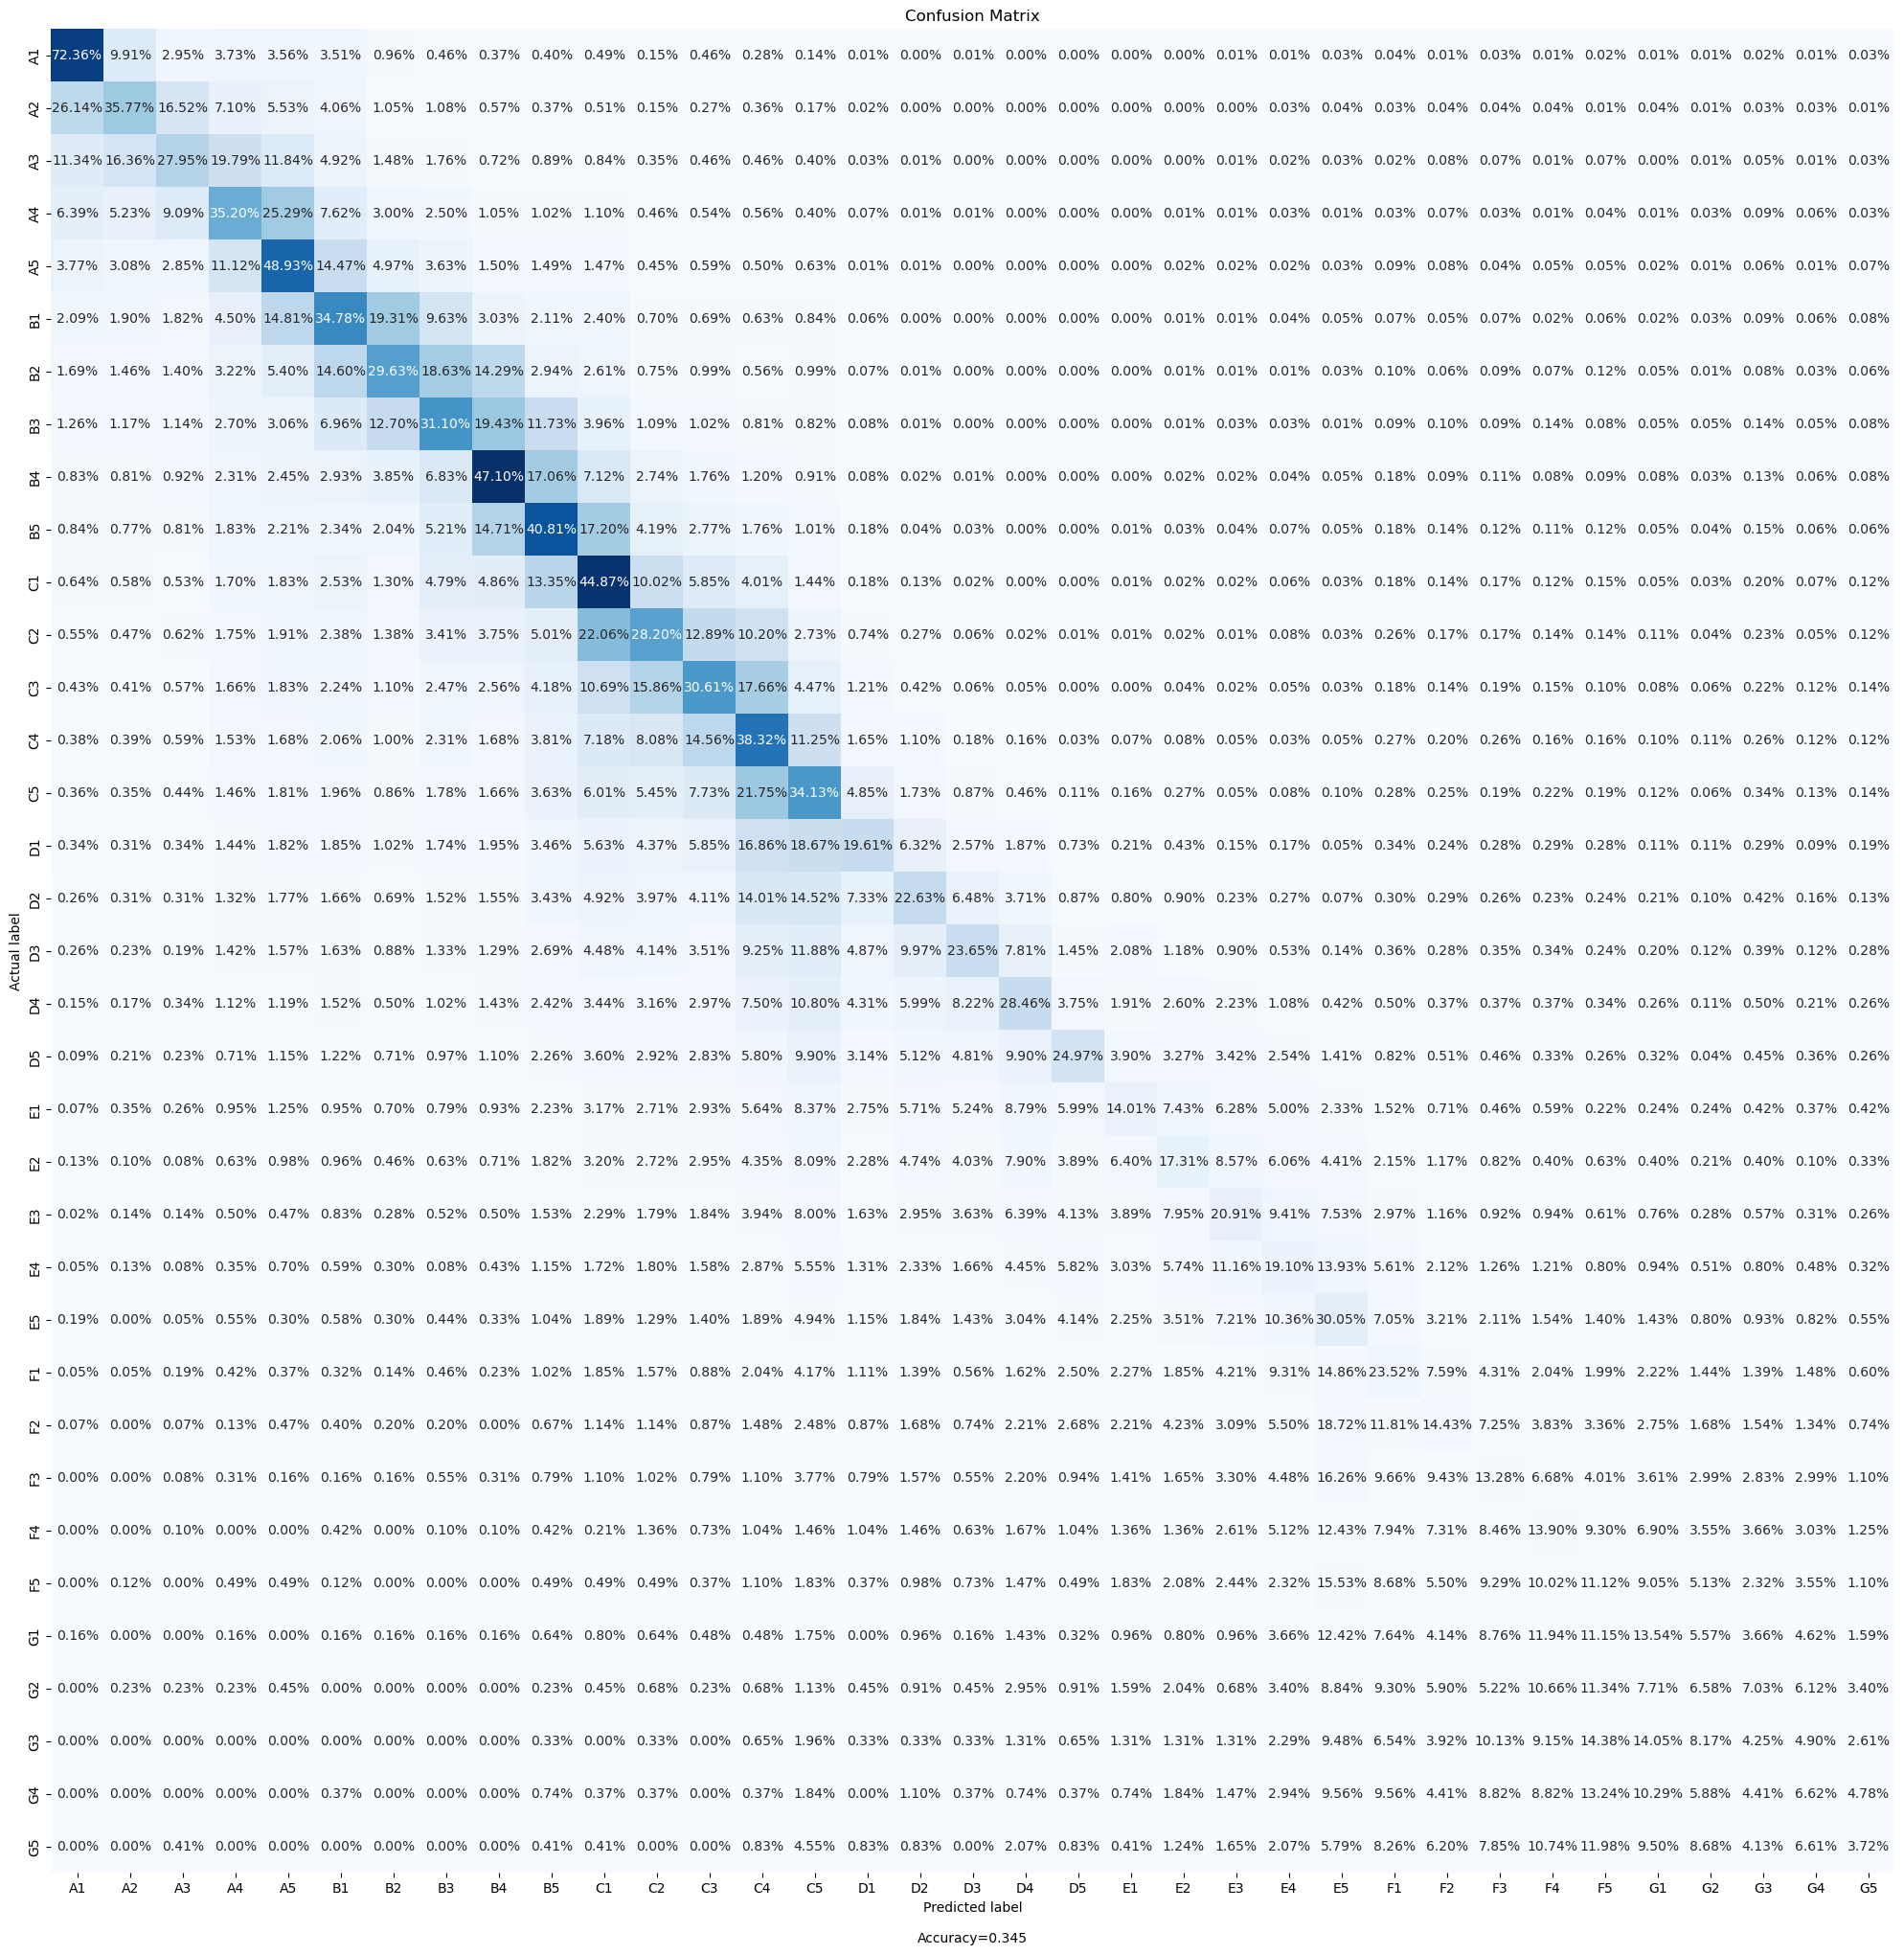

In [9]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict(X_valid_transform)
print(classification_report(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred)
f.plot_confusion_matrix(
    cm,
    figsize=(25, 25),
    categories=categories,
    count=None
)

<Axes: >

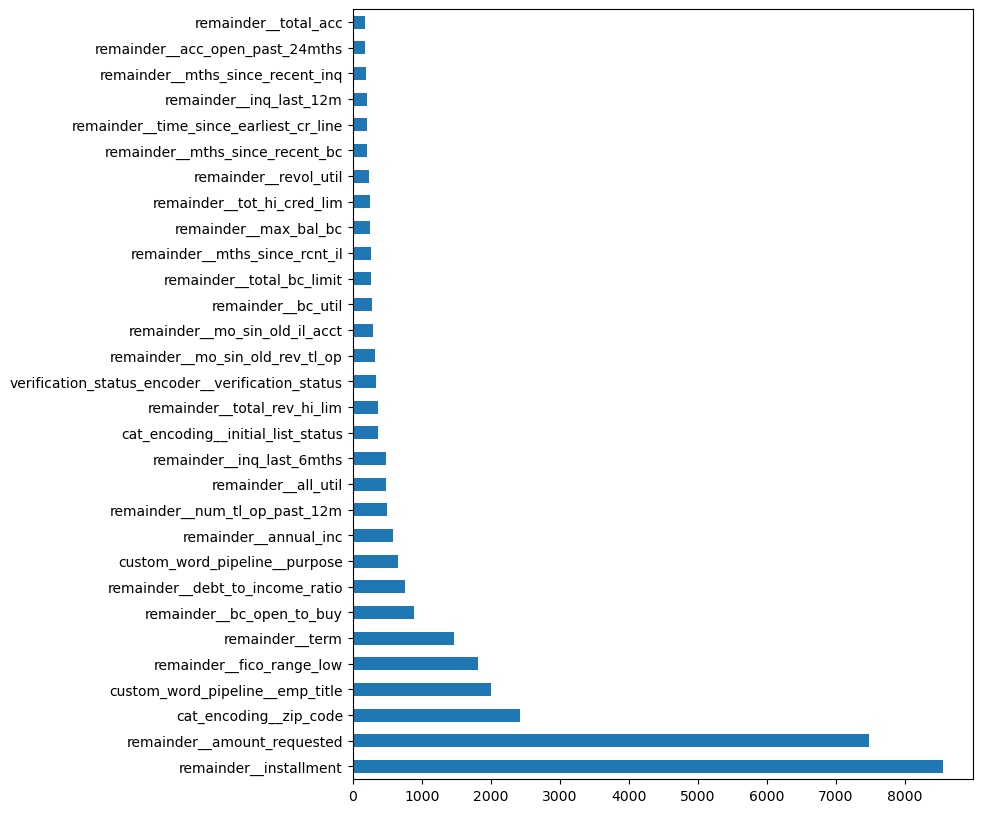

In [10]:
feat_imp = pd.Series(classifier.feature_importances_, index=X_train_transform.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train_transform)
shap.summary_plot(shap_values, X_train_transform)

In [12]:
selected_features = [
    "remainder__installment",
    "remainder__term",
    "remainder__amount_requested",
    "remainder__all_util",
    "custom_word_pipeline__purpose",
    "remainder__fico_range_low",
    "custom_word_pipeline__emp_title",
    "remainder__bc_open_to_buy",
]
features_to_drop = list(set(X_train_transform.columns) - set(selected_features))
final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_features),
        ),
        ("drop_features", DropFeatures(features_to_drop)),
    ]
)
X_train_transform = final_pipeline.fit_transform(X_train)
X_valid_transform = final_pipeline.transform(X_valid)

In [13]:
clf = LGBMClassifier(random_state=1, n_jobs=-1, objective="multiclass", early_stopping_rounds=15)
clf.fit(X_train_transform, y_train, eval_set=[(X_valid_transform, y_valid)], verbose=-1)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMClassifier(early_stopping_rounds=15, objective='multiclass', random_state=1)

MODEL EVALUATION ON VALIDATION SET
              precision    recall  f1-score   support

          A1       0.51      0.72      0.60     13808
          A2       0.36      0.33      0.35     11220
          A3       0.36      0.27      0.31     11629
          A4       0.26      0.35      0.30     15277
          A5       0.30      0.42      0.35     17253
          B1       0.33      0.38      0.35     20070
          B2       0.34      0.25      0.29     20390
          B3       0.31      0.30      0.30     21013
          B4       0.40      0.40      0.40     22491
          B5       0.37      0.40      0.39     22357
          C1       0.26      0.40      0.32     23326
          C2       0.27      0.29      0.28     20922
          C3       0.36      0.30      0.33     20647
          C4       0.28      0.39      0.33     20444
          C5       0.35      0.31      0.33     18605
          D1       0.38      0.23      0.29     13052
          D2       0.37      0.26      0.31   

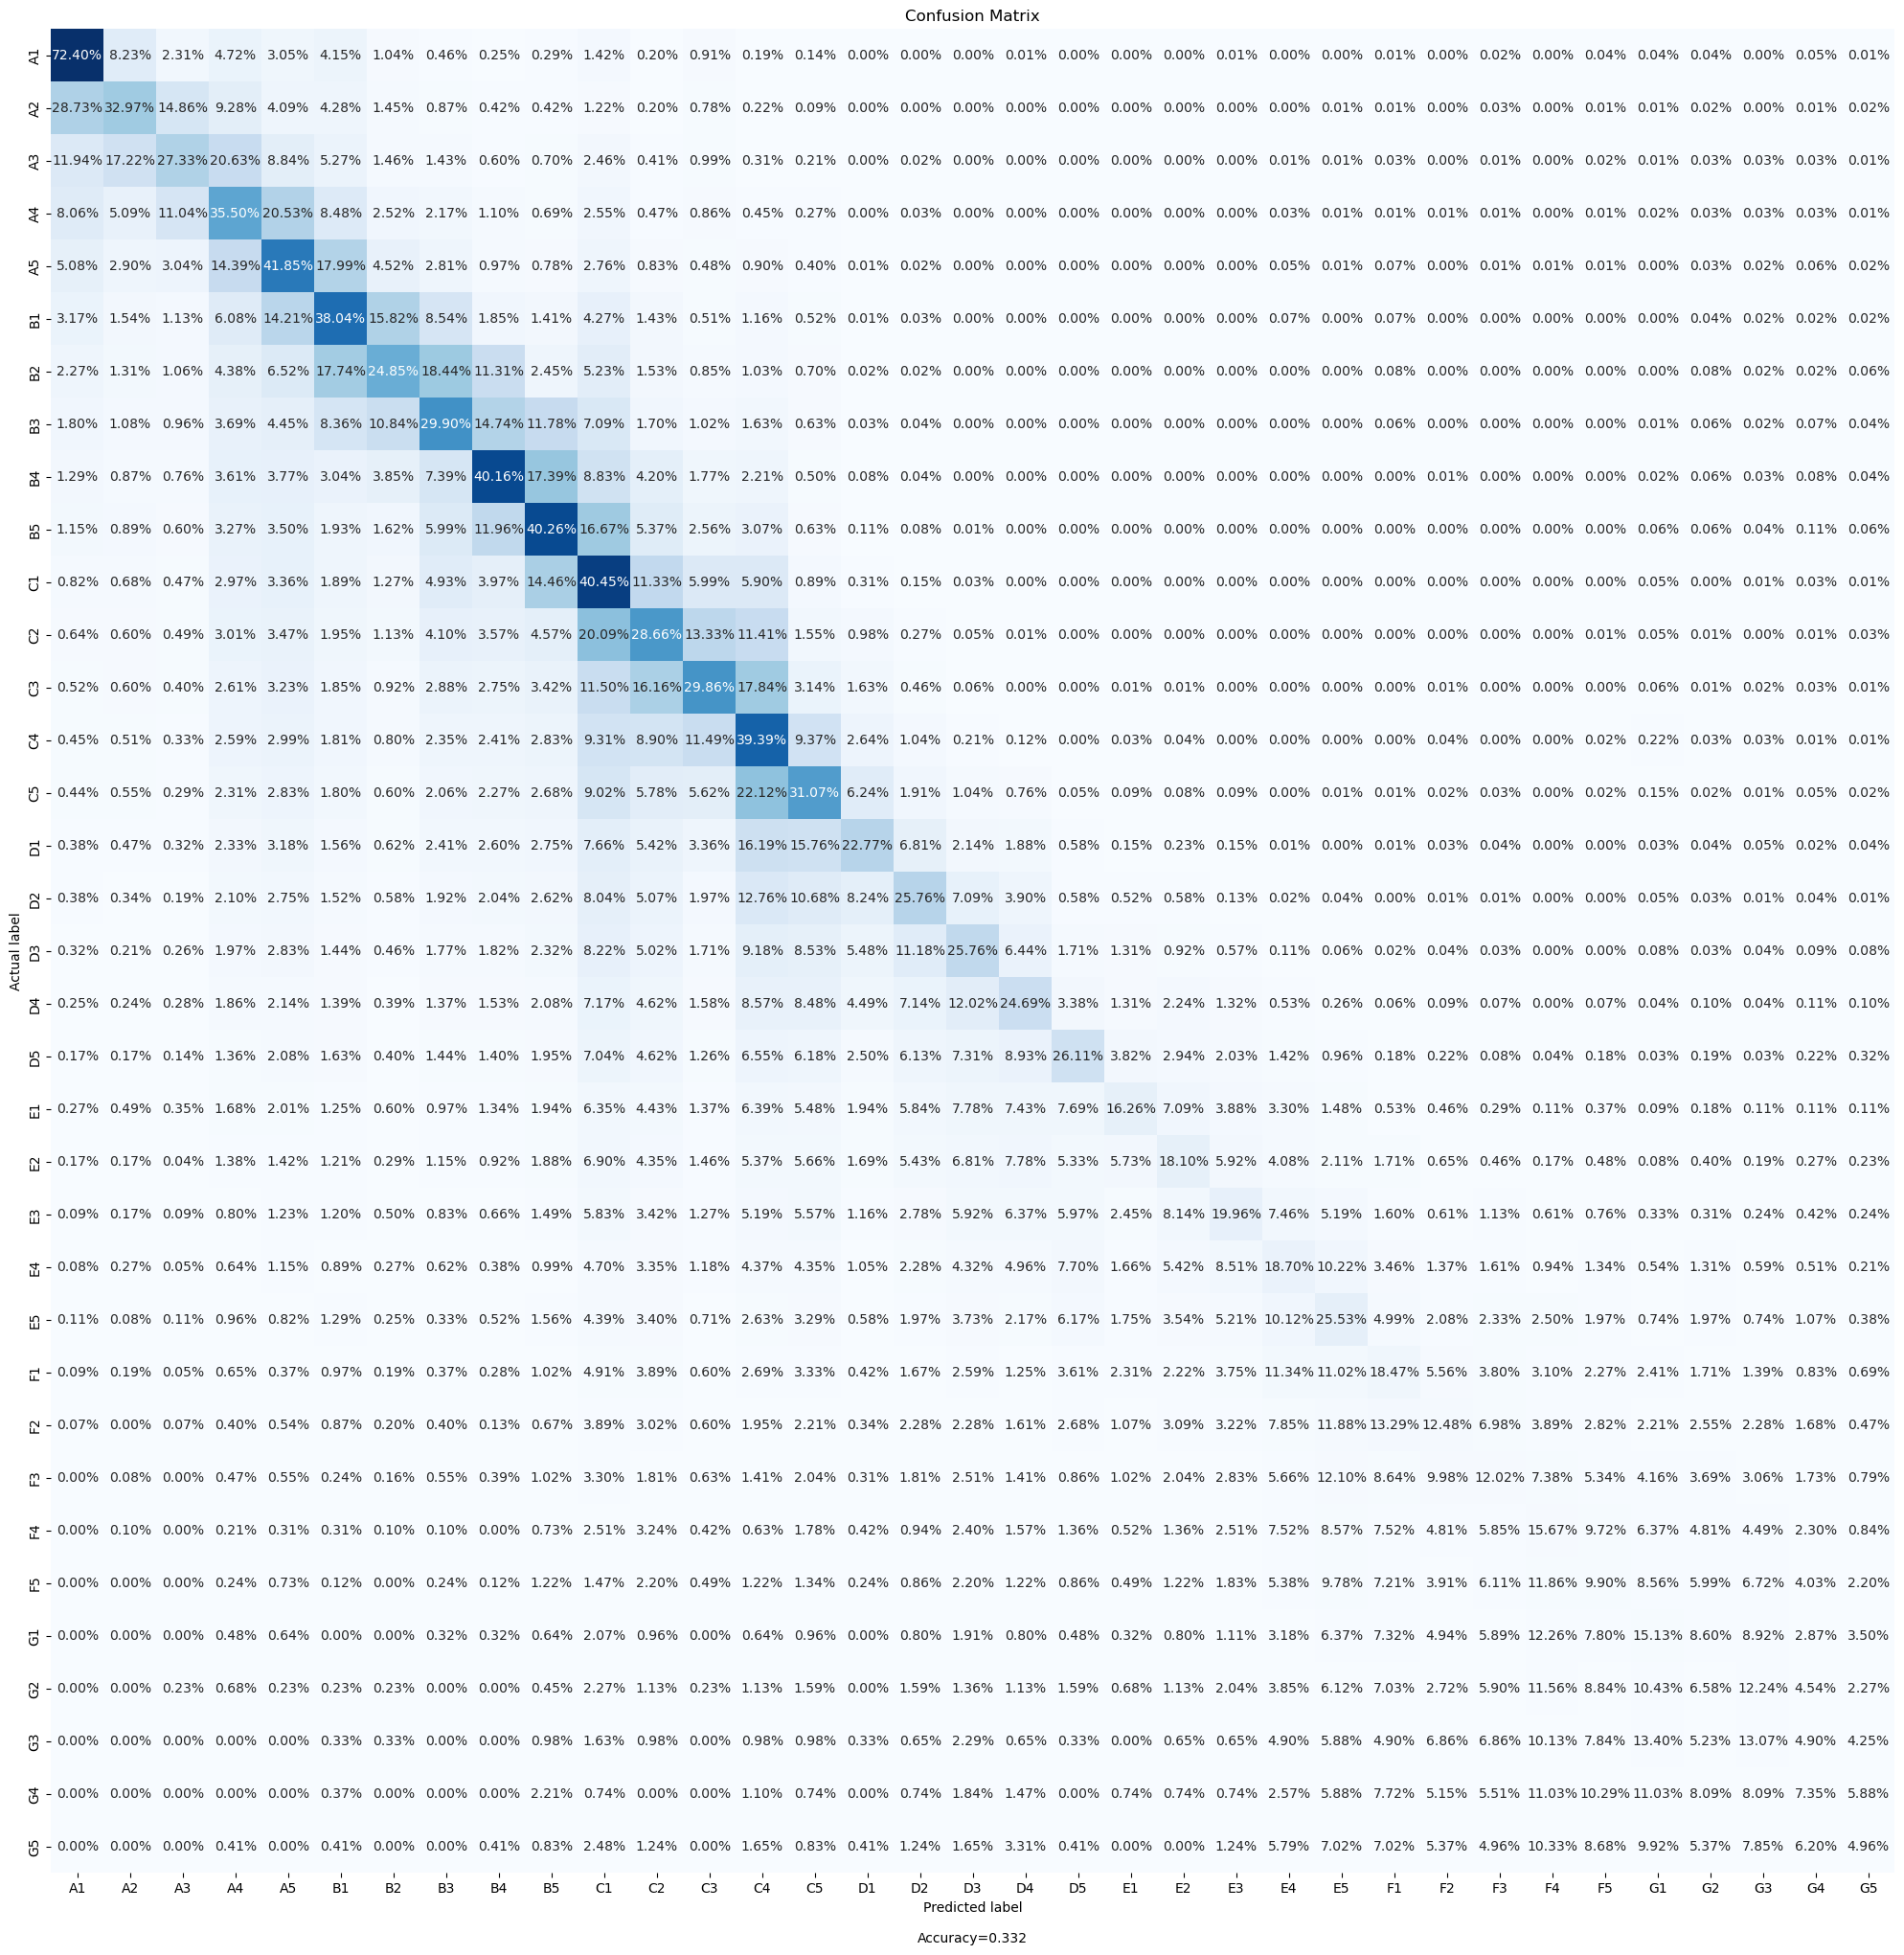

In [14]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = clf.predict(X_valid_transform)
print(classification_report(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred)
f.plot_confusion_matrix(
    cm,
    figsize=(25, 25),
    categories=categories,
    count=None
)

## Final Model Evaluation on Test Set

In [15]:
X_test = test_set.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d", "earliest_cr_line"], axis=1
)
y_test = test_set["sub_grade"]
X_test_transform = final_pipeline.transform(X_test)

MODEL EVALUATION ON TEST SET
              precision    recall  f1-score   support

          A1       0.51      0.72      0.60     17218
          A2       0.37      0.34      0.35     14013
          A3       0.35      0.27      0.31     14586
          A4       0.26      0.35      0.30     19148
          A5       0.30      0.42      0.35     21582
          B1       0.33      0.38      0.35     25070
          B2       0.34      0.25      0.29     25308
          B3       0.31      0.30      0.31     26320
          B4       0.40      0.40      0.40     28190
          B5       0.37      0.40      0.39     28145
          C1       0.26      0.40      0.32     29128
          C2       0.27      0.29      0.28     26388
          C3       0.36      0.30      0.33     25868
          C4       0.27      0.38      0.31     25303
          C5       0.35      0.31      0.33     23294
          D1       0.38      0.23      0.28     16386
          D2       0.38      0.26      0.31     1465

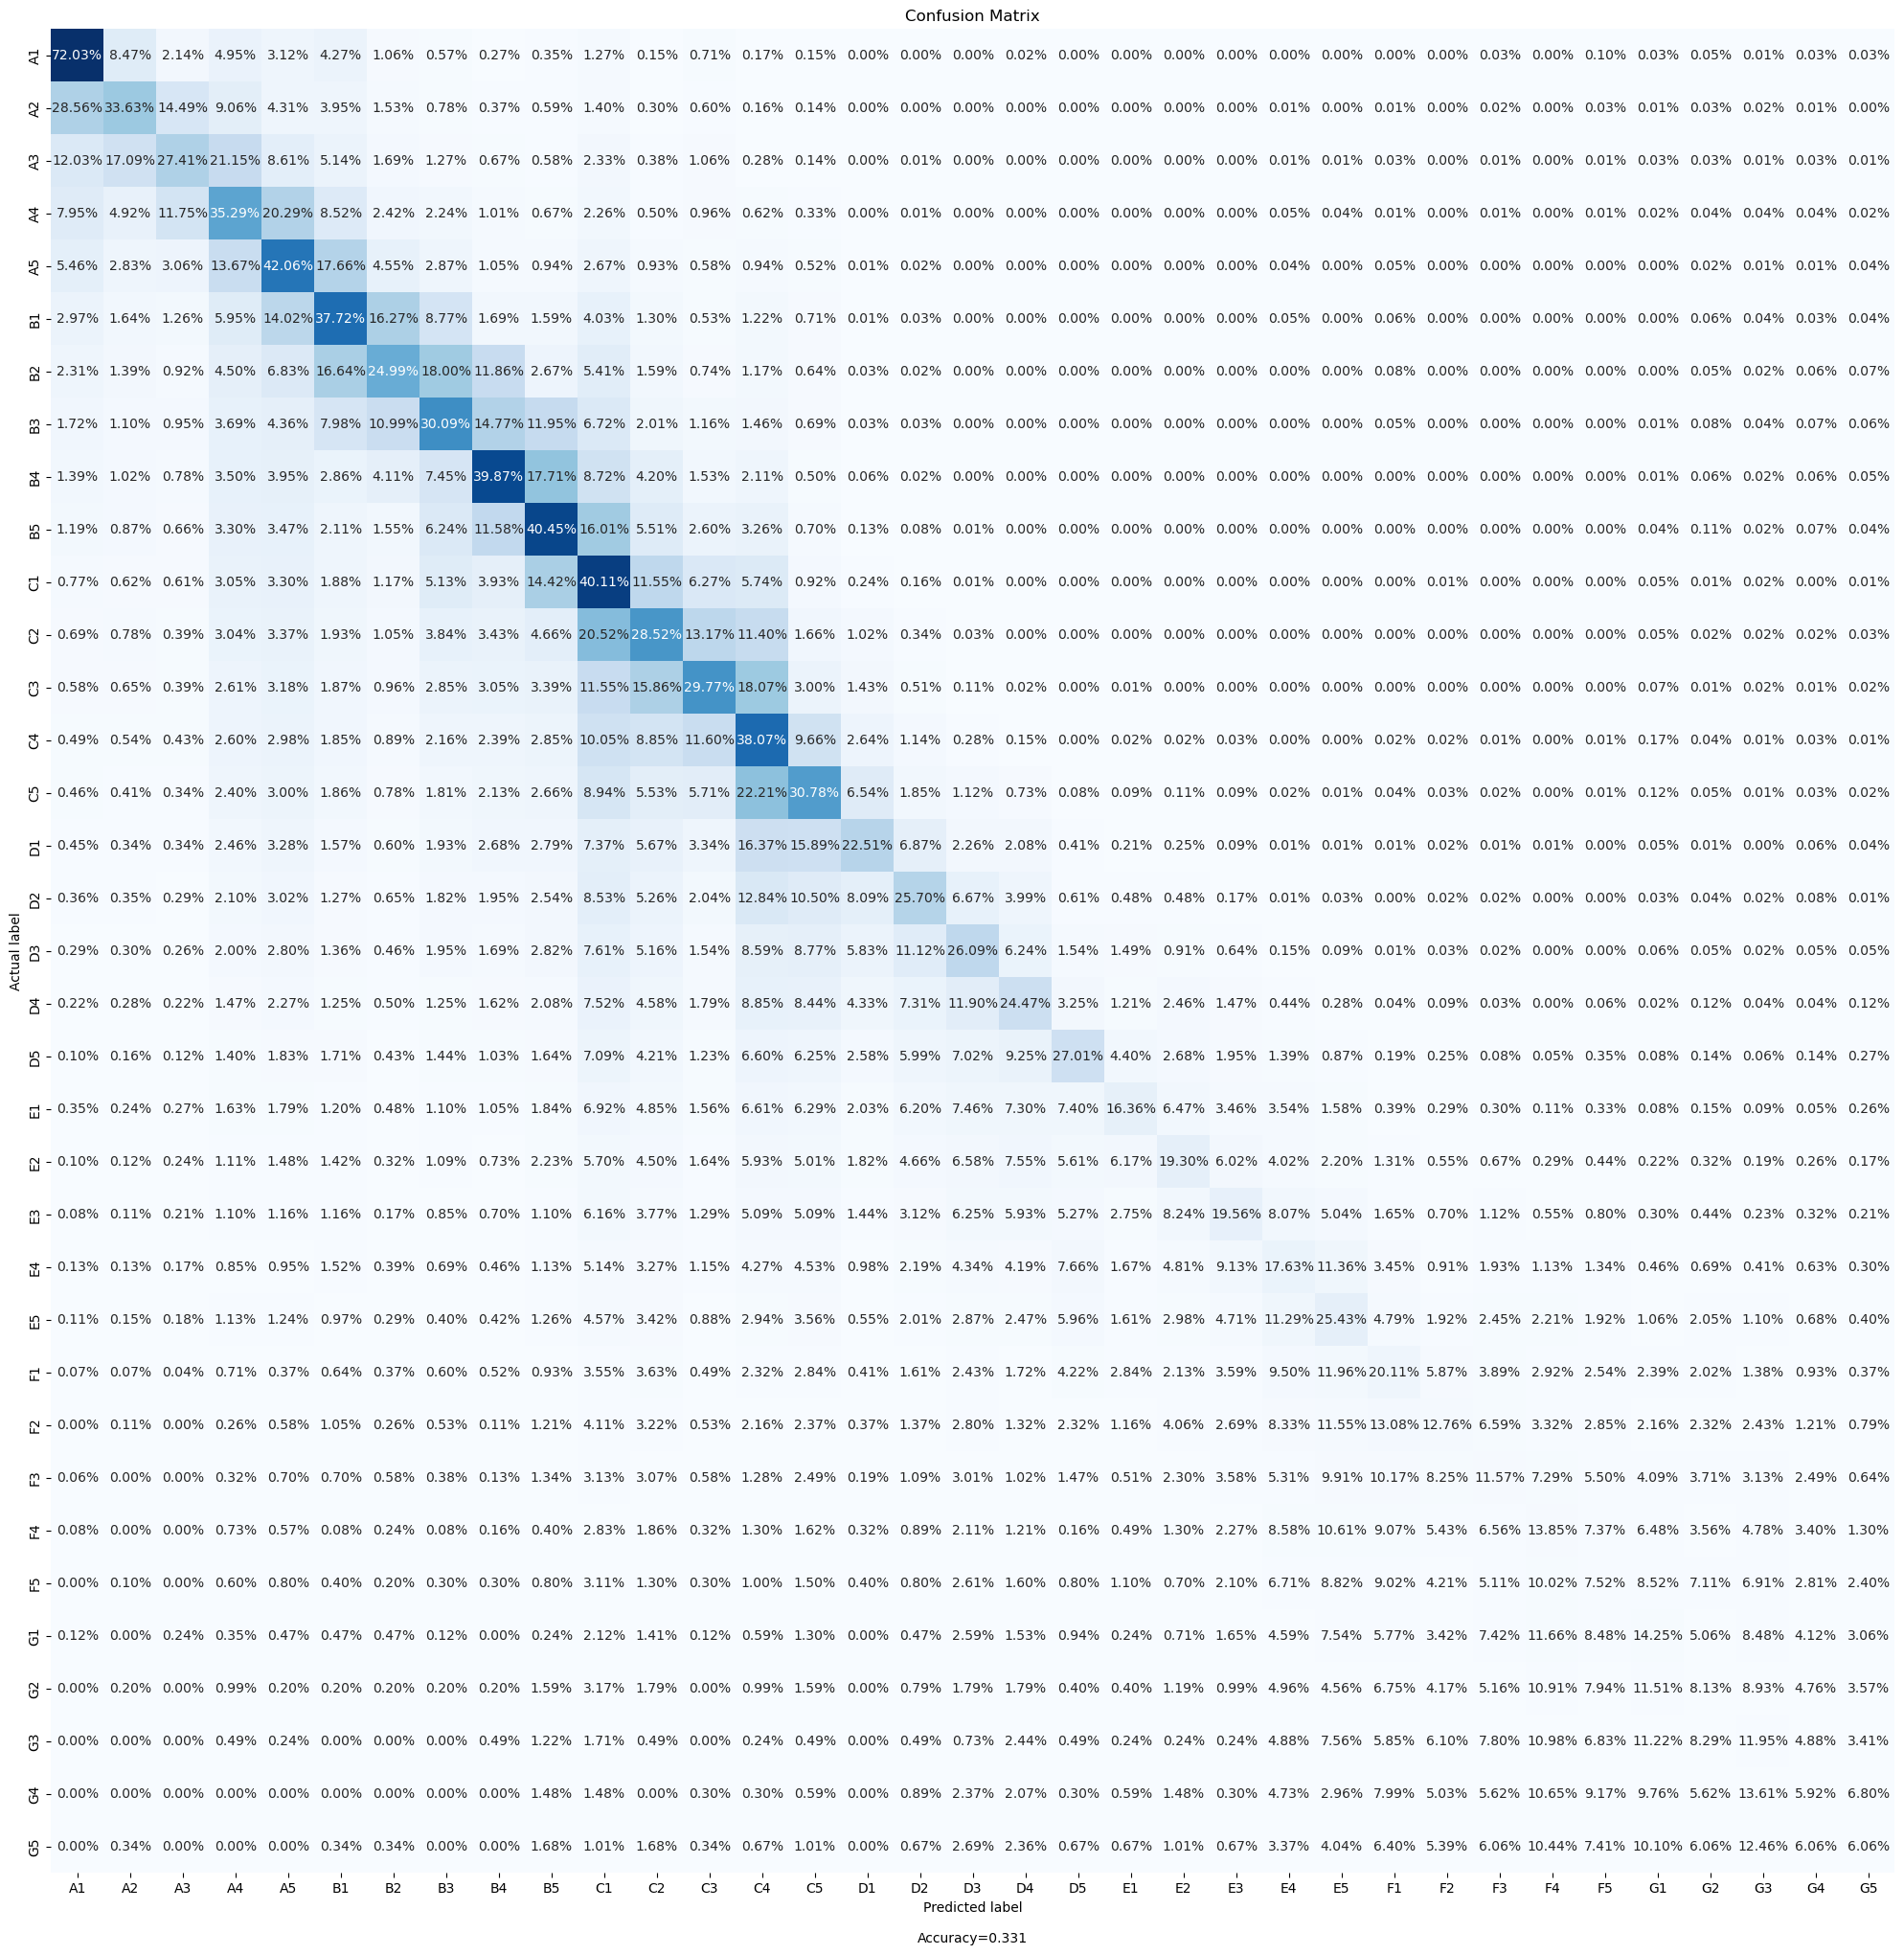

In [16]:
print("MODEL EVALUATION ON TEST SET")
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f.plot_confusion_matrix(
    cm,
    figsize=(25, 25),
    categories=categories,
    count=None
)

## Saving the model

In [17]:
# with open("subgrade_model-0.1.0.pkl", "wb") as f:
#     pickle.dump(clf, f)